# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## 1. Define ResNet18

In [ ]:
class Block(nn.Module):
    """This is courtesy of GeeksForGeeks for the initial implementation."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    """This is courtesy of GeeksForGeeks for the initial implementation."""
    def __init__(self, num_classes=10, in_channels=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.l1 = self._make_layer(Block, 64, 2, stride=1)
        self.l2 = self._make_layer(Block, 128, 2, stride=2)
        self.l3 = self._make_layer(Block, 256, 2, stride=2)
        self.l4 = self._make_layer(Block, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.l1(out)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## 2. Implement training loop and test function

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler):
    losses = []
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = F.nll_loss(F.log_softmax(y_hat, dim=1), y.long())
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            losses.append(loss.item())
    scheduler.step()
    return losses

def test(model, device, test_loader):
    model.eval()
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss += F.nll_loss(F.log_softmax(output, dim=1), y.long(), reduction='sum').item()
            predicted = F.log_softmax(output, dim=1).argmax(dim=1, keepdim=True)
            accuracy += predicted.eq(y.view_as(predicted)).sum().item()

    loss /= len(test_loader.dataset)
    accuracy /= len(test_loader.dataset)

    return loss, accuracy

## 3. MNIST


In [ ]:
MNIST_TRAIN = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
MNIST_TEST = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_size = int(0.8 * len(MNIST_TRAIN))
val_size = len(MNIST_TRAIN) - train_size

MNIST_TRAIN, MNIST_VALIDATION = torch.utils.data.random_split(MNIST_TRAIN, [train_size, val_size])

In [ ]:
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = 64
epochs = 15

In [ ]:
train_dl = torch.utils.data.DataLoader(MNIST_TRAIN, batch_size=batch, shuffle=True)
val_dl = torch.utils.data.DataLoader(MNIST_VALIDATION, batch_size=batch, shuffle=True)
test_dl = torch.utils.data.DataLoader(MNIST_TEST, batch_size=batch, shuffle=True)

In [ ]:
model = ResNet18(in_channels=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
losses = []
validation_losses = []
best = float('inf')
patience = 5
epochs_ = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    loss = train(model, device, train_dl, optimizer, epoch, scheduler)
    losses.append(sum(loss) / len(loss))

    val_loss, _ = test(model, device, val_dl)
    validation_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best:
        best = val_loss
        val_epochs = 0
    else:
        val_epochs += 1

    if val_epochs >= patience:
        print("Early stopping triggered.")
        break

test_loss, test_accuracy = test(model, device, test_dl)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 0 [0/60000]: 2.363223075866699
Epoch 0 [6400/60000]: 0.0958859920501709
Epoch 0 [12800/60000]: 0.05862126499414444
Epoch 0 [19200/60000]: 0.02345641702413559
Epoch 0 [25600/60000]: 0.15377601981163025
Epoch 0 [32000/60000]: 0.037550076842308044
Epoch 0 [38400/60000]: 0.03936805576086044
Epoch 0 [44800/60000]: 0.09916850924491882
Epoch 0 [51200/60000]: 0.0679703801870346
Epoch 0 [57600/60000]: 0.04335598275065422
Epoch 1 [0/60000]: 0.043242938816547394
Epoch 1 [6400/60000]: 0.07244345545768738
Epoch 1 [12800/60000]: 0.04591982066631317
Epoch 1 [19200/60000]: 0.02018342725932598
Epoch 1 [25600/60000]: 0.005440961103886366
Epoch 1 [32000/60000]: 0.03811502829194069
Epoch 1 [38400/60000]: 0.001788186957128346
Epoch 1 [44800/60000]: 0.04237745329737663
Epoch 1 [51200/60000]: 0.005877630319446325
Epoch 1 [57600/60000]: 0.006062049884349108
Epoch 2 [0/60000]: 0.03024829924106598
Epoch 2 [6400/60000]: 0.04174929857254028
Epoch 2 [12800/60000]: 0.031425684690475464
Epoch 2 [19200/60000]: 

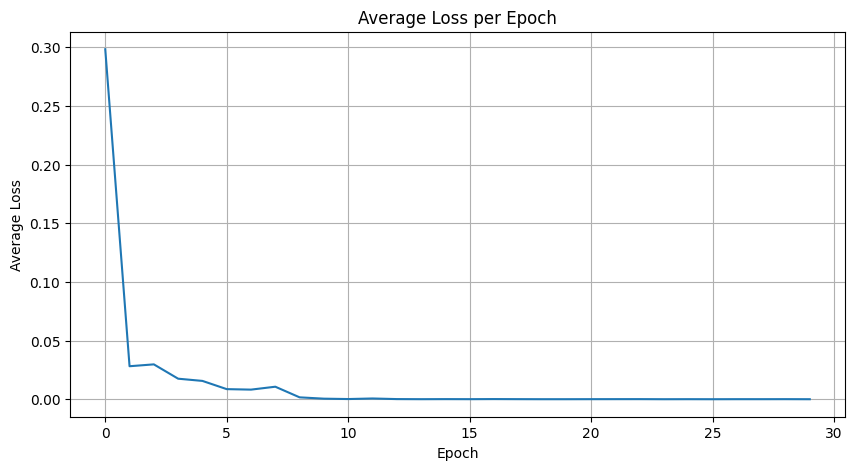

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.grid(True)
plt.show()

# CIFAR10

In [ ]:
CIFAR10_TRAIN = datasets.CIFAR10("./", train=True, transform=transforms.ToTensor(), download=True)
CIFAR10_TEST = datasets.CIFAR10("./", train=False, transform=transforms.ToTensor(), download=True)